In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, Linear, CFlow
from flows.config import floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.02
s0 = 0.6
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[-1] + np.random.normal(scale=s1, size=dim)
    params.append(new)
params = np.array(params, dtype=floatX)

PWalk = NormalRW(None, sigma=s1, sigma0=s0)

In [3]:
params.shape, params[0,0,0]

((32, 3, 4), 0.28286109823949585)

In [4]:
observ_std = 0.07

def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(d, X) + param[:,-1] + np.random.normal(size=[3], scale=observ_std)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(d, X) + param[:,-1]
    return X

In [5]:
xs = [np.random.normal(size=dim[0])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.array(xs)[np.newaxis,:].astype(floatX)

In [6]:
xs

array([[[ 1.93464234e-01, -4.96744938e-01,  1.03272322e+00],
        [ 9.88066639e-01, -2.50255417e-01,  1.91633840e+00],
        [ 1.96182045e+00,  5.80024437e-03,  2.30457015e+00],
        [ 2.44955371e+00, -8.96254044e-02,  2.28996941e+00],
        [ 2.73033306e+00, -3.88082653e-01,  2.40786931e+00],
        [ 3.33949426e+00, -6.57272340e-01,  2.93458886e+00],
        [ 4.07006681e+00, -6.81163747e-01,  3.72121648e+00],
        [ 5.00383995e+00, -3.25654016e-01,  4.63682817e+00],
        [ 6.08402461e+00, -5.02039649e-02,  4.66203809e+00],
        [ 6.12578283e+00, -2.62902274e-01,  4.32057100e+00],
        [ 6.06118591e+00, -7.23245247e-01,  4.56008742e+00],
        [ 6.61207071e+00, -1.17120399e+00,  5.38674060e+00],
        [ 7.93206635e+00, -1.55436791e+00,  6.92610254e+00],
        [ 1.04852709e+01, -1.62524902e+00,  8.79834125e+00],
        [ 1.26904477e+01, -1.85255626e+00,  1.04636082e+01],
        [ 1.53081061e+01, -2.41028833e+00,  1.25110652e+01],
        [ 1.81048403e+01

In [7]:
# conf = [[ResFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)), 
#          NVPFlow(dim=n*dim[0]*dim[1], name='nvp{}'.format(i))] for i in range(2)]
# conf = sum(conf, [])

#conf = [NVPFlow(dim=n*dim[0]*dim[1], name='res{}'.format(i)) for i in range(4)]
#conf = [Linear(dim=n*dim[0]*dim[1])]
conf = [CFlow(dim=n*dim[0]*dim[1], name='CFlow')]

output_flow = DFlow(conf)

In [8]:
output_flow.output

<tf.Variable 'CFlow/W:0' shape=(384,) dtype=float64_ref>

In [9]:
outputs = tf.reshape(output_flow.output, [1,n,dim[0]*dim[1]])

In [10]:
outputs

<tf.Tensor 'Reshape:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs, mean=False)

In [12]:
#outputs = tf.cast(outputs, tf.float64)

In [13]:
prior

<tf.Tensor 'add_2:0' shape=() dtype=float64>

In [14]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=observ_std)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][:,np.newaxis], out[i])
        ll += obs_d.logdens(pred, full_reduce=True, mean=False)
    return ll

In [15]:
logl = create_loglik()

In [16]:
xs.shape

(1, 32, 3)

In [17]:
logl

<tf.Tensor 'add_95:0' shape=() dtype=float64>

In [18]:
ent = output_flow.logdens

In [19]:
ent

0

In [20]:
loss = -logl + ent - prior
loss /= n*dim[0]*dim[1]

In [21]:
opt = tf.train.AdamOptimizer(0.001).minimize(loss)

In [22]:
sess = tf.InteractiveSession()

In [23]:
tf.global_variables_initializer().run()

In [24]:
logl.eval(), prior.eval()

(-272474298.77998143, 1029.4920079349047)

In [28]:
logl.eval(), prior.eval()

(-258228899.94835365, 926.2861565597772)

In [25]:
loss.eval()

709565.8054374311

In [26]:
output_flow.output.assign(params.reshape(-1)).eval()
1233

1233

In [27]:
stage = 0

In [ ]:
for stage in range(stage, stage+160):
    for _ in range(900):
        l, _ = sess.run([loss, opt], {phase:True})
    print(stage, l)

118 80010.77602287986
119 79126.2972223529
120 78255.43568733188
121 77398.07676271022
122 76554.09238599426
123 75723.33956560525
124 74905.66742405329
125 74100.90805066474
126 73308.88538604237
127 72529.41561504613
128 71762.32577454827
129 71007.4648346859
130 70264.70910293107
131 69533.94686578447
132 68815.1235255662
133 68108.16795854714
134 67413.03873785514
135 66729.6887794098
136 66058.0776549549
137 65398.161991818146
138 64749.89936112126
139 64113.245947832176
140 63488.15220654109
141 62874.55955154285
142 62272.40595657094
143 61681.621705814374
144 61102.121908319146
145 60533.8139090071
146 59976.580049493175
147 59430.29392809519
148 58894.75802998803
149 58369.78002450764
150 57855.08036293499
151 57350.29877931247
152 56855.03371089039
153 56368.91007675196
154 55891.70602383775
155 55423.33000088836
156 54963.73840365008
157 54512.856882558175
158 54070.66990440164
159 53637.11545046879
160 53212.142519216
161 52795.699766094
162 52387.71352632047
163 51988.1202

In [28]:
out = tf.reshape(outputs, [n, 3, 4])

In [42]:
samples = []
for _ in range(10):
    s = out.eval()
    samples.append([s[3,2,3], s[4,2,3]])
samples = np.array(samples)

LinAlgError: singular matrix

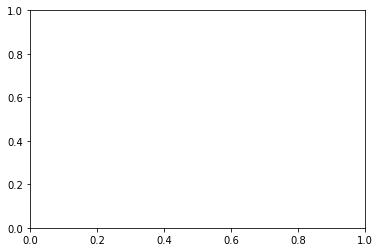

In [32]:
sns.kdeplot(samples[:,0], samples[:,1])
plt.show()

In [30]:
params[0,2,3]

0.4959730111713389

In [31]:
samples[:,0].mean()

0.6030972441361183

In [32]:
a = params[16]

In [44]:
b = out.eval()[16]

In [34]:
a.sum(axis=0)

array([-0.08164042, -1.43486447,  1.87682645, -0.079015  ])

In [35]:
b.sum(axis=0)

array([-0.06143223, -1.27185179,  2.00416019, -0.49927412])

In [36]:
a

array([[ 0.25328412, -0.67880435,  0.77927299, -0.16657356],
       [-0.4189245 ,  0.48321513,  0.44273629, -0.43633546],
       [ 0.08399997, -1.23927524,  0.65481717,  0.52389403]])

In [45]:
b

array([[ 0.25328412, -0.67880435,  0.77927299, -0.16657356],
       [-0.4189245 ,  0.48321513,  0.44273629, -0.43633546],
       [ 0.08399997, -1.23927524,  0.65481717,  0.52389403]])